# Data Preparation Workflow

This notebook demonstrates the data preparation workflow for the Snow Drought Index package. It covers loading data, preprocessing, station extraction and filtering, and data availability assessment.

In [1]:
# Install missing packages
#%pip install bottleneck
#%pip install git+https://github.com/Nadiesenali/snowdroughtindex-main   # Install snowdroughtindex from the local source directory
#%pip install --force-reinstall git+https://github.com/Nadiesenali/snowdroughtindex-main

# Import required packages
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import sys
import datetime


# Import snowdroughtindex package
from snowdroughtindex.core import data_preparation
from snowdroughtindex.utils import visualization, io

First, we'll load the SWE data and other required datasets.

In [6]:
# Define data paths
canswe_path = r"C:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\input_data\CanSWE\CanSWE-CanEEN_1928-2024_v7.nc"
casr_swe = r"C:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\input_data\CASR_SWE\\"
casr_precipitation = r"C:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\input_data\CASR_Precipitation\\"
basin_path = r"C:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\input_data\Elevation\Bow_elevation_combined.shp"
output_data = r"C:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\\"
output_plots = r"C:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_plots\\"

In [7]:
# Load data using the implemented functions
canswe = data_preparation.load_swe_data(canswe_path)
bow_basin = data_preparation.load_basin_data(basin_path)

# Extract CanSWE data for stations within the Bow basin

In [8]:
# Get station locations from canswe
stations_df = pd.DataFrame({
	'station_id': canswe['station_id'].values,
	'lat': canswe['lat'].values,
	'lon': canswe['lon'].values
})

# Create Point geometries for each station
stations_gdf = gpd.GeoDataFrame(
	stations_df,
	geometry=gpd.points_from_xy(stations_df['lon'], stations_df['lat']),
	crs=bow_basin.crs
)

# Find stations within any of the Bow basin polygons
stations_in_basin = stations_gdf[stations_gdf.within(bow_basin.unary_union)]

# Select these stations from canswe
bow_canswe = canswe.sel(station_id=stations_in_basin['station_id'].values)

# Convert to DataFrame
#bow_canswe_df = bow_canswe.to_dataframe().reset_index()

# Save the extracted data to a nc file
bow_canswe.to_netcdf(output_data + 'bow_canswe.nc')


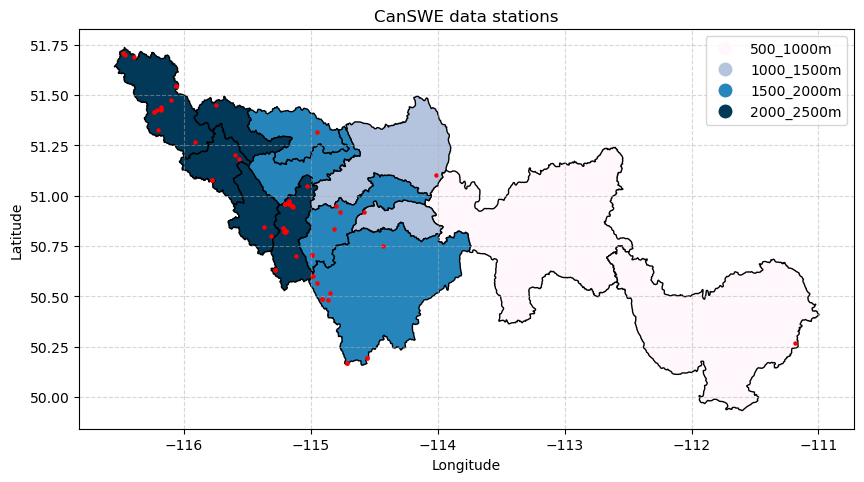

In [9]:
# Plot Bow basin polygons colored by elevation category
fig, ax = plt.subplots(figsize=(10, 10))

# Create elevation class column based on 'mean' elevation
bins = [500, 1000, 1500, 2000, 2500]
labels = ['500_1000m', '1000_1500m', '1500_2000m', '2000_2500m']
bow_basin['elev_class'] = pd.cut(bow_basin['mean'], bins=bins, labels=labels, include_lowest=True, right=False)

# Ensure elev_class is a categorical type with desired order
bow_basin['elev_class'] = pd.Categorical(
    bow_basin['elev_class'],
    categories=labels,
    ordered=True
)

bow_basin.plot(ax=ax, column='elev_class', cmap='PuBu', legend=True, edgecolor='black')
# Add station points
stations_in_basin.plot(ax=ax, color='red', markersize=5, label='Stations')
ax.set_title('CanSWE data stations')
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.savefig(output_plots + 'bow_basin_by_elev_class.png', dpi=300)
plt.show()

## 1. FROSTBYTE gap filling

FROSTBYTE workflow  (In the original workflow, SCDNA precipitation data were also used to increase the data availability. However, here I'm only using CanSWE data because I couldn't find compatible precipitation dataset for the time period 1980-2024)

In [3]:
# Set user-specified variables
flag_buffer_default, buffer_km_default = 0, 0 # buffer flag (0: no buffer around test basin, 1: buffer of value buffer_default around test basin) and buffer default value in km to be applied if flag = 1
month_start_water_year_default, day_start_water_year_default = 10, 1  # water year start
month_end_water_year_default, day_end_water_year_default = 9, 30  # water year end
min_obs_corr_default = 3 # the minimum number of overlapping observations required to calculate the correlation between 2 stations
min_obs_cdf_default = 10 # the minimum number of observations required to calculate a station's cdf
min_corr_default = 0.6 # the minimum correlation value required for donor stations to be selected
window_days_default = 7 # the number of days used on either side of the infilling date for gap filling calculations
min_obs_KGE_default = 3 # the minimum number of observations required to calculate the KGE''
max_gap_days_default = 15  # max. number of days for gaps allowed in the daily SWE data for the linear interpolation
artificial_gap_perc_default = 100 # the percentage of observations to remove during the artificial gap filling for each station & month's first day
iterations_default = 1 # the number of times we repeat the artificial gap filling
artificial_gap_filling_flag = 0 # indicates whether artificial gap filling is performed (1) or not (0)
artificial_gap_filling_basins = ['all'] # a list of the basin(s) to run the gap filling for. To include all basins simply write 'all'

In [ ]:
from snowdroughtindex.core.gap_filling import qm_gap_filling, artificial_gap_filling, plots_artificial_gap_evaluation, 

ImportError: cannot import name 'data_availability_monthly_plots_1' from 'snowdroughtindex.core.gap_filling' (c:\Users\walimunige.rupasingh\AppData\Local\miniconda3\Lib\site-packages\snowdroughtindex\core\gap_filling.py)

In [5]:
# open bow_canswe.nc file
bow_canswe = data_preparation.load_swe_data(output_data + 'bow_canswe.nc')

In [9]:
# Re-organize the dataset as needed
SWE_stations_ds = bow_canswe.assign_coords({'lon':canswe.lon, 'lat':canswe.lat, 'station_name':canswe.station_name, 'elevation':canswe.elevation}).snw
SWE_stations_ds = SWE_stations_ds.to_dataset()

display(SWE_stations_ds)

<xarray.Dataset> Size: 11MB
Dimensions:       (station_id: 78, time: 35277)
Coordinates:
    lat           (station_id) float32 312B 51.7 50.6 50.48 ... 50.49 51.54
    lon           (station_id) float32 312B -116.5 -115.0 ... -114.9 -116.1
    elevation     (station_id) float32 312B ...
    station_name  (station_id) <U50 16kB ...
  * station_id    (station_id) <U16 5kB 'ALE-05BA811' ... 'ALE-05CA805P'
  * time          (time) datetime64[ns] 282kB 1928-01-01 ... 2024-07-31
Data variables:
    snw           (station_id, time) float32 11MB ...

In [10]:
# dataframe of the SWE stations
bow_canswe_df = SWE_stations_ds.to_dataframe().reset_index()

# Extract unique station coordinates
unique_stations = bow_canswe_df.reset_index().drop_duplicates(subset='station_id')[['station_id', 'lon', 'lat']]

# Convert SWE stations DataArray to GeoDataFrame for further analysis
data = {'station_id': unique_stations['station_id'].values, 
        'lon': unique_stations['lon'].values, 
        'lat': unique_stations['lat'].values} 
df = pd.DataFrame(data)
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
crs = "EPSG:4326"
SWE_stations_gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

display(SWE_stations_gdf)

,station_id,lon,lat,geometry
0,ALE-05BA811,-116.466667,51.700001,POINT (-116.46667 51.70000)
1,ALE-05BL801,-114.983330,50.599998,POINT (-114.98333 50.60000)
2,ALE-05BL808,-114.866669,50.483334,POINT (-114.86667 50.48333)
3,BCE-AL04,-114.949997,50.566666,POINT (-114.95000 50.56667)
4,SCD-AL003,-115.566666,51.183334,POINT (-115.56667 51.18333)
...,...,...,...,...
73,ALE-05BF824P,-115.281235,50.632683,POINT (-115.28123 50.63268)
74,ALE-05BJ805P,-114.990013,50.705486,POINT (-114.99001 50.70549)
75,ALE-05BL811P,-114.714371,50.170414,POINT (-114.71437 50.17041)
76,ALE-05BL812P,-114.914162,50.485649,POINT (-114.91416 50.48565)


In [11]:
# Convert test basin SWE data DataSet to Pandas DataFrame for further analysis
SWE_testbasin = SWE_stations_ds.to_dataframe().drop(columns=['lon','lat','station_name']).unstack()['snw'].T

# Remove time from dates
SWE_testbasin['date'] = SWE_testbasin.index.normalize()
SWE_testbasin = SWE_testbasin.set_index('date')

# Drop the dates with no data at all across all stations
SWE_testbasin = SWE_testbasin.dropna(axis=0, how='all')

# Choose data for the period of interest 1980 - 2024
SWE_testbasin = SWE_testbasin.loc['1980-01-01':'2024-07-31']

display(SWE_testbasin)

station_id,ALE-05BA811,ALE-05BL801,ALE-05BL808,BCE-AL04,SCD-AL003,SCD-AL016,SCD-AL022,SCD-AL055,SCD-AL059,SCD-AL081,...,ALE-05BL806,ALE-05BL811,ALE-05BL812,ALE-05CA805,ALE-05BB803P,ALE-05BF824P,ALE-05BJ805P,ALE-05BL811P,ALE-05BL812P,ALE-05CA805P
date,,,,,,,,,,,,,,,,,,,,,
1980-01-01,NaN,NaN,NaN,NaN,25.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-08,NaN,NaN,NaN,NaN,27.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-15,NaN,NaN,NaN,NaN,23.0,NaN,30.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-23,NaN,NaN,NaN,NaN,37.0,NaN,20.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,3.0,0.0
2024-07-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0.0
2024-07-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,3.0,0.0


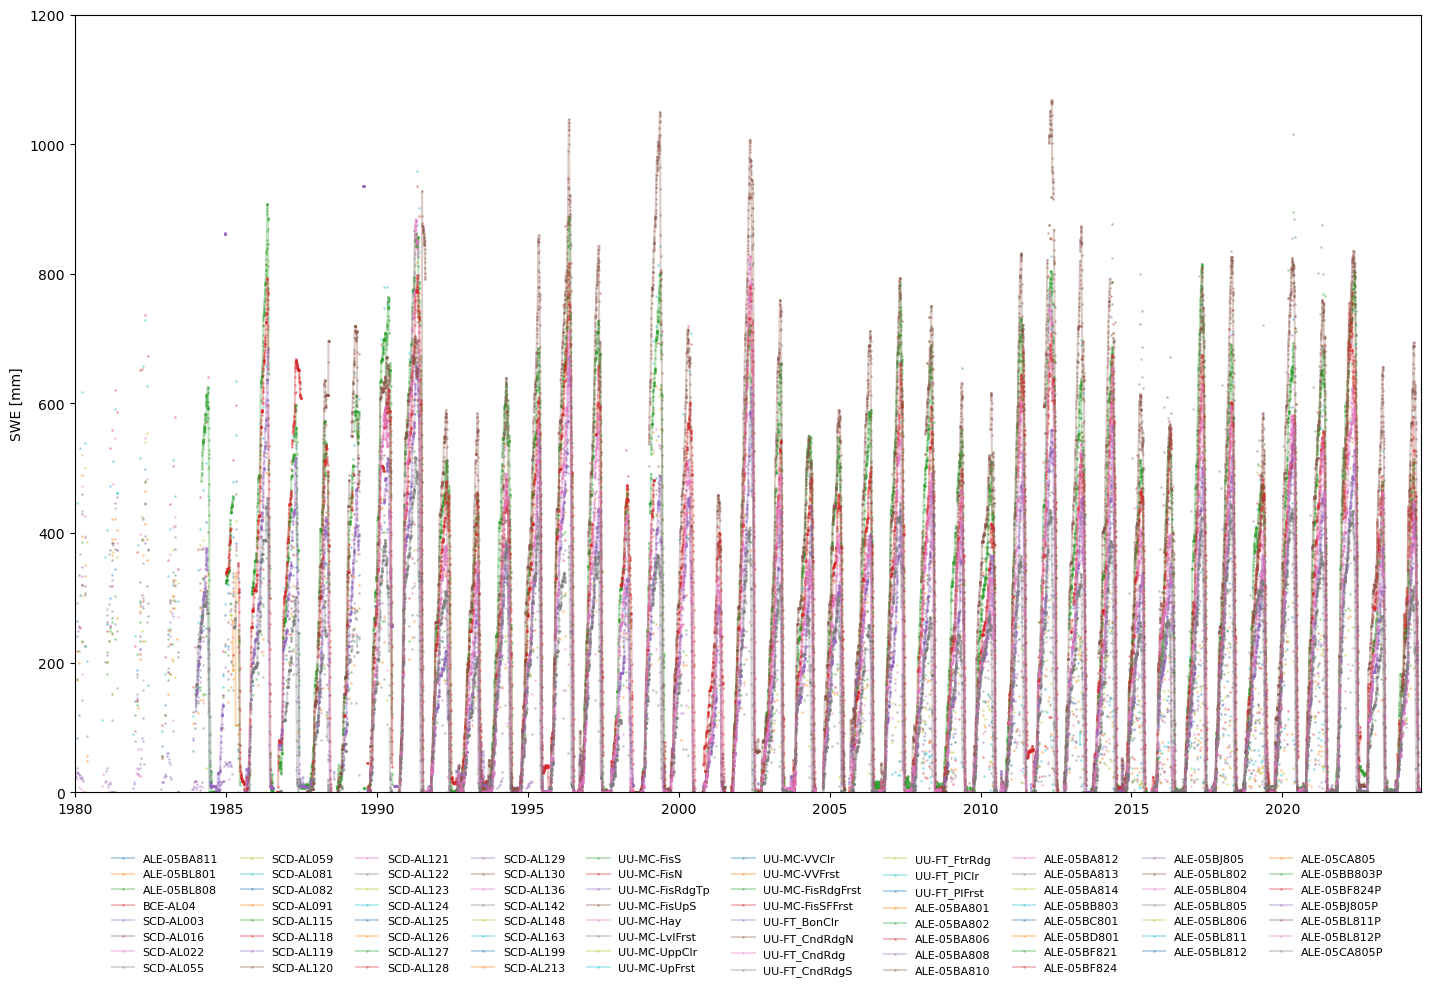

In [30]:
# Plot timeseries of SWE station observations in the test basin
fig = plt.figure(figsize=(15,10))

for s in SWE_stations_ds.station_id.values:
    SWE_stations_ds.snw.sel(station_id = s).plot(marker='o', alpha=.3, markersize=1, label=s)

plt.title('')
plt.ylabel('SWE [mm]')
plt.xlabel('')
plt.xlim(pd.to_datetime('1980-01-01'), pd.to_datetime('2024-07-31'))
plt.ylim(0, 1200)
# Place legend at the bottom with 5 columns per line
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=10, fontsize=8, frameon=False)
plt.tight_layout();

In [52]:
# Linear interpolation to fill in small data gaps
SWE_obs_basin_interp_da = SWE_stations_ds.snw.interpolate_na(method='linear', dim='time', max_gap=datetime.timedelta(days=max_gap_days_default))
SWE_obs_basin_interp_df = SWE_obs_basin_interp_da.to_dataframe().drop(columns=['lon','lat','station_name']).unstack()['snw'].T
SWE_obs_basin_interp_df['date'] =  SWE_obs_basin_interp_df.index.normalize()
SWE_obs_basin_interp_df = SWE_obs_basin_interp_df.set_index('date')

In [53]:
# Save flags for linear interpolation to a new Pandas dataframe (observations = 0; estimates = 1)
flags_interp_basin_da = SWE_obs_basin_interp_da.copy().fillna(-999)
original_da = SWE_stations_ds.snw.copy().fillna(-999)
flags_interp_basin_da = xr.where(flags_interp_basin_da==original_da, 0, 1)
flags_interp_basin_df = flags_interp_basin_da.to_dataframe().drop(columns=['lon','lat','station_name']).unstack()['snw'].T
flags_interp_basin_df['date'] =  flags_interp_basin_df.index.normalize()
flags_interp_basin_df = flags_interp_basin_df.set_index('date')

In [54]:
# Perform gap filling for the original dataset (no artificial gaps, flag=0)
# Note: this may take quite a while to run, depending on the number of gaps to fill

# Ensure only valid station IDs are included (intersection with bow_canswe['station_id'])
valid_station_ids = set(bow_canswe['station_id'].values)
SWE_testbasin_filtered = SWE_testbasin.loc[:, SWE_testbasin.columns.intersection(valid_station_ids)]

SWE_obs_basin_gapfilled_df, flags_gapfill_basin_df, donor_stations_gapfill_basin_df = qm_gap_filling(
	SWE_testbasin_filtered.copy(),
	window_days=window_days_default,
	min_obs_corr=min_obs_corr_default,
	min_obs_cdf=min_obs_cdf_default,
	min_corr=min_corr_default
)

Memory usage after chunk 1: 3956.00 MB


In [55]:
# Combine gapfill and linear interpolation flags into a single Pandas dataframe
flags_basin_df = flags_interp_basin_df + flags_gapfill_basin_df

In [57]:
# Save gap filled dataset and metadata to single dataset
SWE_gapfill_basin_da = xr.DataArray(data=SWE_obs_basin_gapfilled_df.values, coords=dict(time=SWE_obs_basin_gapfilled_df.index.values, station_id=SWE_obs_basin_gapfilled_df.columns.values), dims=['time','station_id'], name='SWE', attrs={'long_name':'Surface snow water equivalent','units':'kg m**-2'})
flags_basin_da = xr.DataArray(data=flags_basin_df.values, coords=dict(time=flags_basin_df.index.values, station_id=flags_basin_df.columns.values), dims=['time','station_id'], name='flag', attrs={'description':'observations = 0; estimates = 1'})
donor_stations_gapfill_basin_da = xr.DataArray(data=donor_stations_gapfill_basin_df.values, coords=dict(time=donor_stations_gapfill_basin_df.index.values, station_id=donor_stations_gapfill_basin_df.columns.values), dims=['time','station_id'], name='donor_stations', attrs={'description':'station_id of donor stations used for gap filling'})
SWE_obs_basin_gapfilled_ds = xr.merge([SWE_gapfill_basin_da, flags_basin_da, donor_stations_gapfill_basin_da])
lats = SWE_stations_ds.lat.sel(station_id=SWE_obs_basin_gapfilled_df.columns.values).values
lons = SWE_stations_ds.lon.sel(station_id=SWE_obs_basin_gapfilled_df.columns.values).values
names = SWE_stations_ds.station_name.sel(station_id=SWE_obs_basin_gapfilled_df.columns.values).values
SWE_obs_basin_gapfilled_ds = SWE_obs_basin_gapfilled_ds.assign_coords({'lat':('station_id',lats),'lon':('station_id',lons),'station_name':('station_id',names)})
SWE_obs_basin_gapfilled_ds.attrs['info'] = 'Gap filled SWE data for basin. The gap filling was done using a combination of linear interpolation and quantile mapping, using donor data from neighbouring SWE stations in the same basin.'

In [58]:
# Plot bar chart of the number of times each donor station was used for gap filling
count = []
for s in SWE_testbasin.columns.values:
    count_s = SWE_obs_basin_gapfilled_ds.donor_stations.where(SWE_obs_basin_gapfilled_ds.donor_stations==s).count().data
    count.append(count_s)
fig = plt.figure()
plt.bar(SWE_testbasin.columns.values, count, color='b')
plt.xticks(rotation=90)
# xlabes are too many. so add them as a legend and x label as 1,2,3... according to the number of stations
plt.legend(SWE_testbasin.columns.values)
plt.xlabel('Donor stations')
plt.ylabel('# times used for gap filling')
plt.savefig(output_plots+'donor_stations_gapfilling_in_basin.png', dpi=300, bbox_inches='tight')
plt.close(fig)

# Plot timeseries of the % of SWE stations with data in the test basin on the first day of each month, for the original data & after gap filling (flag=1)
#fig = data_availability_monthly_plots_1(SWE_stations_ds, SWE_stations_ds.snw, SWE_obs_basin_gapfilled_ds.SWE, flag=1)
#plt.xlim(1978,2024)
#plt.show
#plt.savefig(output_path+'SWEobs_monthly_availability_1_gapfilling_in_basin.png', dpi=300)
#plt.close(fig)

Memory usage after chunk 1: 3969.93 MB


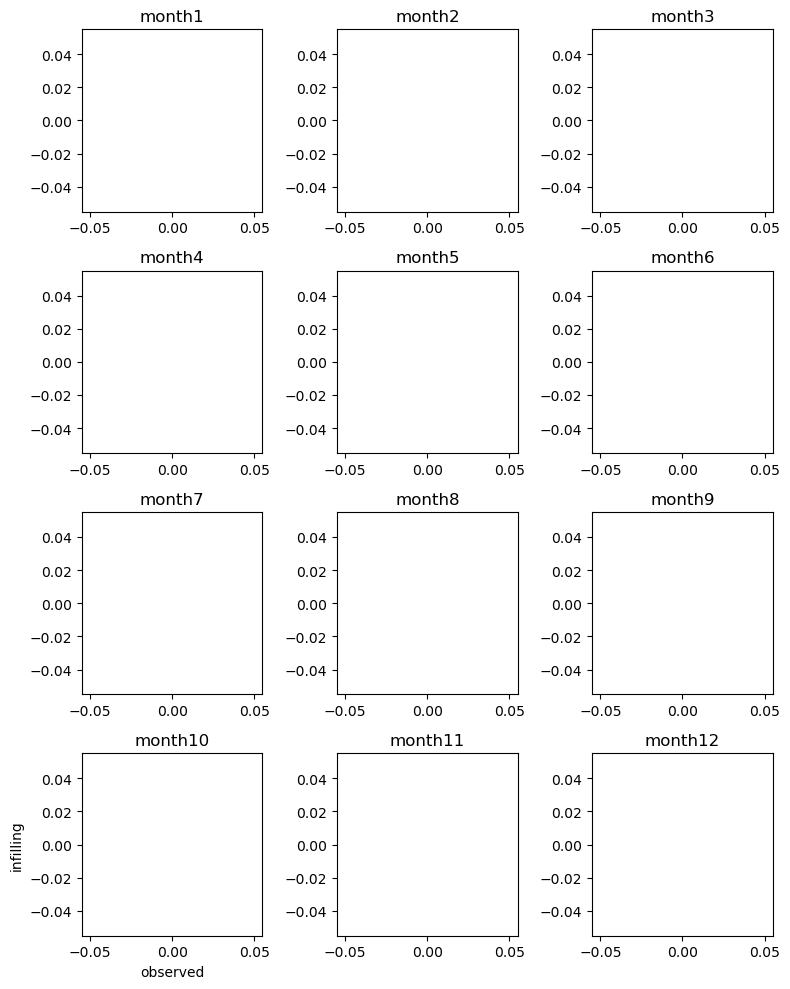

In [60]:
# Perform artificial gap filling evaluation and plot the results (flag=1)
# Note: this may take quite a while to run, depending on the number of gaps to fill
pd.set_option("mode.chained_assignment", None) # suppresses the "SettingWithCopyWarning"

evaluation_artificial_gapfill_testbasin_dict, fig = artificial_gap_filling(SWE_testbasin.copy(), iterations=iterations_default, artificial_gap_perc=artificial_gap_perc_default, window_days=window_days_default, min_obs_corr=min_obs_corr_default, min_obs_cdf=min_obs_cdf_default, min_corr=min_corr_default, min_obs_KGE=min_obs_KGE_default, flag=1)

In [ ]:
plt.savefig(output_plots+'SWE_artificial_gapfilling_in_basin.png', dpi=300)
plt.close(fig)

In [61]:
# Plot artificial gap filling evaluation results
fig = plots_artificial_gap_evaluation(evaluation_artificial_gapfill_testbasin_dict)
plt.savefig(output_plots+'SWE_artificial_gapfilling_eval_in_basin.png', dpi=300)
plt.close(fig)

In [62]:
# Artificial gap filling & eveluation  #
# -------------------------------------#

if artificial_gap_filling_flag == 1:

     if (artificial_gap_filling_basins == 'all') :

        print('Performing an artificial gap filling in basin ')

        # Perform artificial gap filling evaluation
        # Note: if flag=1 we also output a figure of the artificial gap filling values against the observed values for visual comparison
        evaluation_artificial_gapfill_basin, fig = artificial_gap_filling(SWE_testbasin.copy(), iterations=iterations_default, artificial_gap_perc=artificial_gap_perc_default, window_days=window_days_default, min_obs_corr=min_obs_corr_default, min_obs_cdf=min_obs_cdf_default, min_corr=min_corr_default, min_obs_KGE=min_obs_KGE_default, flag=1)
        plt.savefig(output_plots+'SWE_artificial_gapfilling_in_basin.png', dpi=300)
        plt.close(fig)

        # Plot artificial gap filling evaluation results
        fig = plots_artificial_gap_evaluation(evaluation_artificial_gapfill_basin)
        plt.savefig(output_plots+'SWE_artificial_gapfilling_eval_in_basin.png', dpi=300)
        plt.close(fig)

In [63]:
# Save basin gap filled SWE data to netcdf
SWE_obs_basin_gapfilled_ds.to_netcdf(output_data+'SWE_gapfilled_for_basin_new.nc', format="NETCDF4")

In [ ]:
# open the saved netcdf file
SWE_obs_basin_gapfilled_ds = xr.open_dataset(output_data+'SWE_gapfilled_for_basin_new.nc')
# Convert the gap filled dataset to Pandas DataFrame for further analysis
SWE_obs_basin_gapfilled_df = SWE_obs_basin_gapfilled_ds.to_dataframe().reset_index()

#plot the gap filled SWE data
fig, ax = plt.subplots(figsize=(10, 6))
SWE_obs_basin_gapfilled_df.plot(x='date', y=SWE_obs_basin_gapfilled_df.columns[2:], ax=ax, legend=False)
ax.set_title('Gap Filled SWE Data for Bow Basin')
ax.set_xlabel('Date')
ax.set_ylabel('SWE (kg m**-2)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(output_plots + 'SWE_gapfilled_for_basin_plot.png', dpi=300)

## 6. Summary

In this notebook, we've demonstrated the data preparation workflow for the Snow Drought Index package. We've loaded data, preprocessed it, extracted stations within the basin of interest, assessed data availability, and saved the processed data for use in subsequent analyses.

The workflow uses the following key functions from the `data_preparation` module:
- `load_swe_data()`, `load_precip_data()`, `load_basin_data()` for data loading
- `preprocess_swe()`, `preprocess_precip()` for data preprocessing
- `convert_to_geodataframe()` for converting data to GeoDataFrame
- `extract_stations_in_basin()` for extracting stations within a basin
- `filter_stations()` for filtering data by station
- `assess_data_availability()` for assessing data availability

These functions provide a standardized and reusable way to prepare data for the Snow Drought Index calculations.